In [1]:
%matplotlib inline
import os
from glob import glob

import calendar
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.path as mpath

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean

import util

## Read SeaWiFS climatology

Data downloaded manually (login required) from here:
https://oceandata.sci.gsfc.nasa.gov/SeaWiFS/Mapped/Monthly_Climatology/9km/chl_gsm/


In [2]:
seawifs_sh_file = 'data/seawifs/monthly_climatology/chl_gsm/seawifs_L3m_MC_GSM_chl_gsm_9km.zarr'
if not os.path.exists(seawifs_sh_file):

    data_dir = '/glade/work/mclong/seawifs/chl_gsm'
    files = glob(f'{data_dir}/*.nc')
    assert len(files) == 12 # ensure that we have 12 files

    # file names have code SYYYYDOYYYYYDOY, 
    # where YYYY is year and DOY is day of year
    # and two YYYYDOY specify first and last dates of data in the file
    # so we'll sort by the first DOY to get in month order
    # get first DOY
    doy_start = [os.path.basename(f)[5:8] for f in files]

    # sort the file list by the doy_start list
    files = [f for _, f in sorted(zip(doy_start, files))]

    # generate a list of datasets, one for each month, subsetting in latitude as we go
    dsets = [xr.open_dataset(f, drop_variables=['palette']) for f in files]

    months = [calendar.month_name[i][:3] for i in range(1, 13)]
    time = xr.DataArray(months, name='month', dims=('month'))

    ds = xr.concat(dsets, dim=time)        
    
    # compute grid-cell area (promote to double precision for computation)
    dx = ds.longitude_step.astype(np.float64)
    dy = ds.latitude_step.astype(np.float64)
    ds.lon.values = ds.lon.values.astype(np.float64)
    ds.lat.values = ds.lat.values.astype(np.float64)
    util.compute_grid_area(ds, dx=dx, dy=dy, check_total=True)
    
    # subset southern ocean domain
    ds = ds.sel(lat=slice(-30, -90))
    
    # write to zarr archive
    ds.to_zarr(seawifs_sh_file)

else:
    ds = xr.open_zarr(seawifs_sh_file)

ds = ds.compute()
ds

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 4320, month: 12)
Coordinates:
  * lat      (lat) float64 -30.04 -30.13 -30.21 -30.29 ... -89.79 -89.88 -89.96
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * month    (month) <U3 'Jan' 'Feb' 'Mar' 'Apr' ... 'Sep' 'Oct' 'Nov' 'Dec'
Data variables:
    area     (lat, lon) float64 7.433e+07 7.433e+07 ... 6.244e+04 6.244e+04
    chl_gsm  (month, lat, lon) float32 0.0774553 0.07744174 ... nan nan
Attributes:
    Conventions:                       CF-1.6 ACDD-1.3
    _lastModified:                     2018-02-01T11:55:18.000Z
    cdm_data_type:                     grid
    creator_email:                     data@oceancolor.gsfc.nasa.gov
    creator_name:                      NASA/GSFC/OBPG
    creator_url:                       http://oceandata.sci.gsfc.nasa.gov
    data_bins:                         4918763
    data_maximum:                      203999543296.0
    data_minimum:                      0.00019056067685596645
    date_created:                      2018-02-01T11:55:18.000Z
    easternmost_longitude:             180.0
    end_orbit_number:                  66564
    geospatial_lat_max:                90.0
    geospatial_lat_min:                -90.0
    geospatial_lat_resolution:         9.27662467956543
    geospatial_lat_units:              degrees_north
    geospatial_lon_max:                180.0
    geospatial_lon_min:                -180.0
    geospatial_lon_resolution:         9.27662467956543
    geospatial_lon_units:              degrees_east
    grid_mapping_name:                 latitude_longitude
    history:                           l3mapgen par=S19980012010031.L3m_MC_GS...
    id:                                S19980012010031.L3b_MC_GSM.nc/L3/S1998...
    identifier_product_doi:            10.5067/ORBVIEW-2/SEAWIFS/L3M/GSM/2018
    identifier_product_doi_authority:  http://dx.doi.org
    institution:                       NASA Goddard Space Flight Center, Ocea...
    instrument:                        SeaWiFS
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    l2_flag_names:                     ATMFAIL,LAND,HILT,HISATZEN,STRAYLIGHT,...
    latitude_step:                     0.0833333358168602
    latitude_units:                    degrees_north
    license:                           http://science.nasa.gov/earth-science/...
    longitude_step:                    0.0833333358168602
    longitude_units:                   degrees_east
    map_projection:                    Equidistant Cylindrical
    measure:                           Mean
    naming_authority:                  gov.nasa.gsfc.sci.oceandata
    northernmost_latitude:             90.0
    number_of_columns:                 4320
    number_of_lines:                   2160
    platform:                          Orbview-2
    processing_level:                  L3 Mapped
    processing_version:                2018.0
    product_name:                      S19980012010031.L3m_MC_GSM_chl_gsm_9km.nc
    project:                           Ocean Biology Processing Group (NASA/G...
    publisher_email:                   data@oceancolor.gsfc.nasa.gov
    publisher_name:                    NASA/GSFC/OBPG
    publisher_url:                     http://oceandata.sci.gsfc.nasa.gov
    southernmost_latitude:             -90.0
    spatialResolution:                 9.28 km
    standard_name_vocabulary:          CF Standard Name Table v36
    start_orbit_number:                2237
    suggested_image_scaling_applied:   No
    suggested_image_scaling_maximum:   20.0
    suggested_image_scaling_minimum:   0.009999999776482582
    suggested_image_scaling_type:      LOG
    sw_point_latitude:                 -89.95833587646484
    sw_point_longitude:                -179.9583282470703
    temporal_range:                    12-year
    time_coverage_end:                 2010-01-30

/glade/work/mclong/miniconda3/envs/krill/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


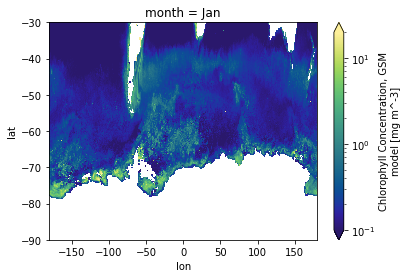

In [3]:
cmap = cmocean.cm.haline
norm = colors.LogNorm(vmin=0.1, vmax=20.)

ds.sel(month='Jan').chl_gsm.plot(norm=norm, cmap=cmap)

/glade/work/mclong/miniconda3/envs/krill/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


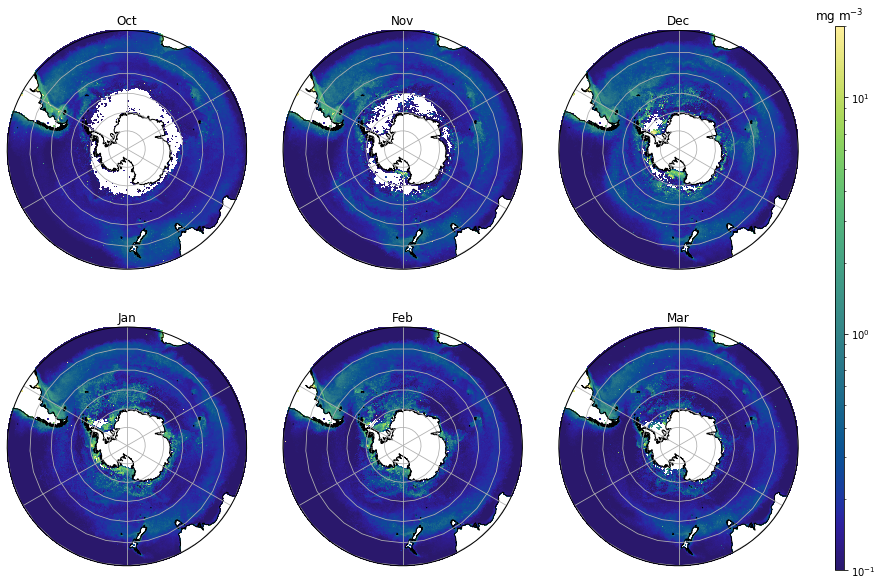

In [4]:
lat = ds.lat.values
lon = ds.lon.values

fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(nrows=2, ncols=4, width_ratios=(1, 1, 1, 0.04))

for i, mon in enumerate(['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']):   

    row, col = np.unravel_index(i, (2, 3))
    
    ax = fig.add_subplot(gs[row, col], projection=ccrs.SouthPolarStereo())
    ax.set_extent([180, -180, -90,  -30], crs=ccrs.PlateCarree())

    data = ds.chl_gsm.sel(month=mon).values
    
    cf = ax.pcolormesh(lon, lat, data,
                       cmap=cmap,
                       norm=norm,
                       transform=ccrs.PlateCarree())

    ax.coastlines('50m')
    ax.gridlines()

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)

    ax.set_title(mon)
    
cax = fig.add_subplot(gs[:, -1])    
cb = plt.colorbar(cf, cax=cax)
cb.ax.set_title('mg m$^{-3}$');